# Bilateral Histogram Equalization

## 1. Import useful libraries and open the sample image

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

hdr_img = cv.imread("image/image.tif", -1)
cv.imshow('TiffExemple',hdr_img)
cv.waitKey(0)
cv.destroyAllWindows()


## 2. Show histogram of the sample HDR image

[0.0000e+00 1.0000e+00 2.0000e+00 ... 6.5534e+04 6.5535e+04 6.5536e+04]
65537


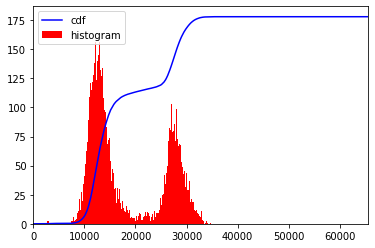

In [2]:

max_bit = 2**16
hist,bins = np.histogram(hdr_img.flatten(),max_bit,[0,max_bit])
print(bins)
print(len(bins))
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(hdr_img.flatten(),max_bit,[0,max_bit], color = 'r')
plt.xlim([0,max_bit])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

## 3. Streched sample histogram

### 3.1 Show the resulting image from the stretching operation

In [4]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*max_bit/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint16')

img_stretch = cdf[hdr_img]

cv.imshow('TiffStretchExemple',img_stretch)
cv.waitKey(0)
cv.destroyAllWindows()

### 3.2 Plot the streched histogram

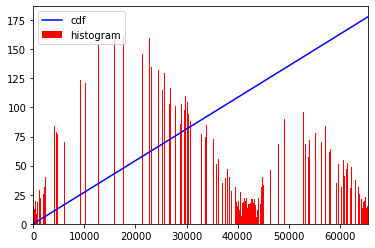

In [5]:
max_bit = 2**16
hist,bins = np.histogram(img_stretch.flatten(),max_bit,[0,max_bit])


cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img_stretch.flatten(),max_bit,[0,max_bit], color = 'r')
plt.xlim([0,max_bit])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

# 4. Toolbox to get weight maps, slices and fusion

In [6]:
from Bilateral_histogram_equalisation import showImageHDR
from typing import List

def getSlices(hdr_img: np.array, bins: int) -> List[np.ndarray]:
    """Cut image into equal sized bins.
    Args:
        hdr_img (np.ndarray): HDR image array.
        bins (int): Number of desired bins.

    Returns:
        List[nd.array]: List of image slices array.
    """
    M, N = hdr_img.shape
    x = np.linspace(0,M*N, bins)
    sk = []
    for i in range(bins-1):
        null_compare = hdr_img[:,:] >= x[i+1]
        if i > 0: 
            slice = (hdr_img - x[i]) / (x[i+1] - x[i])
            slice = slice*null_compare
            m, n = np.where(hdr_img >= x[i])
            slice[m,n] = hdr_img[m, n]
        else:
            slice = hdr_img
        sk.append(slice)
    return sk

def getWeightMap(hdr_img: np.array, bins: int) -> List[np.ndarray]:
    """Find the best candidate for the weight map wk.
    Args:
        hdr_img (np.ndarray): HDR image array.
        bins (int): Number of desired bins.

    Returns:
        List[np.ndarray]: List of weight maps array.
    """
    M, N = hdr_img.shape
    x = np.linspace(0, M*N, bins) 
    wk = []
    for i in range(bins -1):
        one_compare = hdr_img[:,:] <= x[i]
        null_compare = hdr_img[:,:] >= x[i+1]
        other_compare = (~ one_compare)*(~ null_compare)
        ik = other_compare*hdr_img
        wk.append(ik)
    return wk

def fusion(weightMap: List[np.ndarray], slices: List[np.ndarray], bins: int) -> np.ndarray: 
    """Fusion of two given array is based on the sum of their product.
    Args:
        weightMap (List[np.ndarray]): Weightmap array.
        slices (List[np.ndarray]): Slices array.
        bins (int): Number of desired bins.

    Returns:
        np.ndarray: Fusioned weightmap and slices array.
    """
    output = []
    for i in range(bins -1):
        output.append(weightMap[i] @ slices[i])
    result = output[0]
    for i in range(1, bins -1):
        result += output[i].astype('uint16')
    showImageHDR(result)
    return result

## 5. Get slices and weigth maps then fusion both array to show the final result

In [8]:
sk = getSlices(hdr_img, bins=30)
wk = getWeightMap(hdr_img, bins=30)
fusion(wk, sk, bins=30)

array([[11454, 57749, 47619, ..., 44779, 56270, 53882],
       [64673,  1007, 56953, ..., 50637, 56371, 56613],
       [46914, 51262, 54263, ..., 25870,  7055,  2434],
       ...,
       [57909, 63136, 26981, ..., 48803, 38667,  8478],
       [34662, 60682, 51122, ..., 17555, 50461, 13040],
       [57079, 54426, 19233, ..., 28032, 19194, 61806]], dtype=uint16)